In [1]:
import numpy as np
import multiprocessing as mp
#import ipyparallel as ipp
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import vegas
from scipy.integrate import quad
from scipy.interpolate import interp1d
from functools import partial

In [2]:
class constant:
    """
    Containing multiple physical constants and conversion factors
    
    Conversion factors
    ------
    md2MeVperCubicCM: Msun/kpc^3 to MeV/cm^3
    md2MeVperQuadCM: Msun/kpc^3 to MeV/cm^2
    year2Seconds
    erg2MeV
    
    Masses (MeV)
    ------
    me: electron
    mn: neutron
    mp: proton
    Msun: Solar mass
    
    Lengths (cm)
    ------
    kpc2cm
    
    Physical constants
    ------
    c: light speed, cm/s
    H0: Hubble constant, km/s/Mpc
    rho_c: critical density, Msun/pc^3
    Lv: SN neutrino luminosity, single specie, erg/s
    """
    # conversion factors 
    md2MeVperCubicCM = 3.796e-5
    md2MeVperQuadCM = 1.171e17
    year2Seconds = 3.156e7
    erg2MeV = 624150.913
    
    # masses (MeV)
    me = 0.511
    mn = 939.564
    mp = 938.272
    Msun = 1.115e57
    
    # lengths (cm)
    kpc2cm = 3.085e21
    
    # The total stellar mass of the Milky Way
    Mmw = 5.29e10
    
    # physical constants
    c = 2.998e10 # cm/s
    H0 = 73 # km/s/Mpc
    rho_c = 1.5e-7 # Msun/pc^3
    Lv = 3e52/6 # SNv luminosity, single specie
    Omega_0m = 0.315
    Omega_0L = 0.685
    Omega_0r = 0.0023
    Omega_0 = 1.0023
    D_H0 = 4280 # Mpc

### Milky Way mass distribution functions

Taken from McMillan, *MNRAS* **465**, 76 (2017). The inputs $(R,z)$ are in cylindrical coordinate and $r$ is in spherical coordinate. The output unit for all density profiles is $M_\odot\,{\rm kpc}^{-3}$. The conversion from $M_\odot\,{\rm kpc}^{-3}$ to ${\rm MeV\,cm}^{-3}$ is to multiply $3.796\times 10^{-5}$ on the original output.
#### The bulge
Assuming axisymmetric density profile
$$
\rho_b(R,z)=\frac{\rho_{0,b}}{[1+r^\prime(R,z)/r_0]^\alpha}\exp\left[-\frac{r^{\prime 2}(R,z)}{r_{\rm cut}^2}\right]
$$
with
$$
r^\prime = \sqrt{R^2+(z/q)^2}
$$
where $\alpha=1.8$, $r_0=0.075$ kpc, $r_{\rm cut}=2.1$ kpc, $q=0.5$ and $\rho_{0,b}=9.93\times 10^{10}M_\odot\,{\rm kpc}^{-3}$.

#### The gas discs
It follows
$$
\rho_d(R,z)=\frac{\Sigma_0}{4z_d}\exp\left(-\frac{R_m}{R}-\frac{R}{R_d}\right){\rm sech}^2\left(\frac{z}{2z_d}\right)
$$
where for two components H<span style="font-variant:small-caps;">i</span> and molecular gas the parameters are listed in the below table

| Disc | $R_d$ (kpc)| $R_m$ (kpc) |$z_d$ (kpc)|$\Sigma_0\,(M_\odot\,{\rm kpc}^{-2})$|
| :-----:| :----: | :----: |:----:|:----:|
| H<span style="font-variant:small-caps;">i</span> |7| 4 |0.085|$5.31\times 10^{7}$|
| H<sub>2</sub> | 1.5 | 12 |0.045|$2.18\times 10^9$|

#### The stellar discs
Stellar disc is commonly decomposed into a thin and thick discs and are modelled by 
$$
\rho_d(R,z)=\frac{\Sigma_0}{2z_d}\exp\left(-\frac{|z|}{z_d}-\frac{R}{R_d}\right)
$$
with the parameters are listed below

|Disc|$\Sigma_0\,(M_\odot\,{\rm kpc}^{-2})$|$R_d$ (kpc)|$z_d$ (kpc)|
| :-----:| :-----:| :-----:| :-----:|
|thin|$8.96\times 10^8$|2.5|0.3|
|thick|$1.83\times 10^8$|3.02|0.9|

#### The dark matter halo
It follows
$$
\rho_\chi(r) = \frac{\rho_{0,h}}{x^\gamma (1+x)^{3-\gamma}}
$$
where $x=r/r_h$ and $r$ is the radius to the center in spherical coordinate. The parameters are $\gamma=1$ for NFW profile, $\rho_{0,h}=8.54\times 10^{6}M_\odot\,{\rm kpc}^{-3}$ and $r_h=19.6$ kpc.

In [3]:
class mwDensityProfile(constant):
    """
    This class evaluates the galactic mass density profiles for bulge, stellar disc and gas disc based on McMillan, MNRAS 465, 76 (2017).
    The unit is M_sun per cubic kpc.
    """
    
    def __init__(self):
        pass
    
    def __gasForm(R,z,Rd,Rm,zd,Sigma0):
        """
        Eq. (4)
        """
        R = np.abs(R)
        return Sigma0*np.exp(-Rm/R - R/Rd)/np.cosh(z/2/zd)**2/4/zd
    
    def __stellarForm(R,z,Rd,zd,Sigma0):
        """
        Eq. (3)
        """
        R= np.abs(R)
        return Sigma0*np.exp(-np.abs(z)/zd - R/Rd)
        
    @classmethod
    def stellarThin(cls,R,z):
        """
        Density profile for stellar thin disc at (R,z) in kpc
        Parameter values from Tab. 3
        """
        return cls.__stellarForm(R,z,2.5,0.3,8.96e8)
    
    @classmethod
    def stellarThick(cls,R,z):
        """
        Density profile for stellar thick disc at (R,z) in kpc
        Parameter values from Tab. 3
        """
        return cls.__stellarForm(R,z,3.02,0.9,1.83e8)
    
    @classmethod
    def gasHI(cls,R,z):
        """
        Density profile for HI molecules at (R,z) in kpc
        Parameter values from Tab. 1
        """
        return cls.__gasForm(R,z,7,4,0.085,5.31e7)
    
    @classmethod
    def gasH2(cls,R,z):
        """
        Density profile for H2 molecules at (R,z) in kpc
        Parameter values from Tab. 1
        """
        return cls.__gasForm(R,z,1.5,12,0.045,2.18e9)
    
    @staticmethod
    def bulge(R,z):
        """
        Density profile for bulge at (R,z) in kpc, Eq. (1)
        """
        # Eq. (1)
        # constants
        a = 1.8
        q = 0.5
        rho_0b = 9.93e10
        r_0 = 0.075
        r_cut = 2.1
        # variables
        r_p = np.sqrt(R**2 + (z/q)**2)
        # rho_b
        rho_b = rho_0b*np.exp(-r_p/r_cut)/(1 + r_p/r_0)**a
        return rho_b
    
class mwAreaDensityProfile(mwDensityProfile):
    """
    This class evaluates the galactic area density with profiles inherited from mwDensityProfiles.
    The unit is M_sun per quardic kpc except.
    """
    
    def __init__(self):
        pass
    
    """
    Area density has been integrated the mass density over z
    """
    
    def __integ(func,zrange,err_msg):
        I = quad(func,zrange[0],zrange[1])
        if err_msg:
            return I
        else:
            return I[0]
    
    @classmethod
    def areaDensity(cls,R,zrange=[-5,5],component='StarFormation',err_msg=False):
        """
        Integrate over z axis and obtains area density M_sun per quad kpc
    
        Input
        -----
        R : the distance to GC, kpc
        zrange : bound of the z-integration, default is [-5,5] kpc
        
        Output
        ------
        tuple : (MeV per quad kpc, error), using scipy.optimize.quad
        """
        # check if the component option existed, if not, raise error
        if component == 'StarFormation':
            func = lambda z: cls.stellarThin(R,z) + cls.stellarThick(R,z) + cls.bulge(R,z)
            return cls.__integ(func,zrange,err_msg)
        elif component == 'gasHI':
            return cls.__integ(lambda z: cls.gasHI(R,z),zrange,err_msg)
        elif component == 'gasH2':
            return cls.__integ(lambda z: cls.gasH2(R,z),zrange,err_msg)
        elif component == 'stellarThin':
            return cls.__integ(lambda z: cls.stellarThin(R,z),zrange,err_msg)
        elif component == 'stellarThick':
            return cls.__integ(lambda z: cls.gasThick(R,z),zrange,err_msg)
        elif component == 'bulge':
            return cls.__integ(lambda z: cls.bulge(R,z),zrange,err_msg)
        else:
            raise NotImplementedError('Component:\'' + component + '\' is not implemented')

In [292]:
# Generating table of areal density in advance for later interpolation
# This would increase the computational speed without doing integration everytime
R_list = np.linspace(0,100,201)
rho_m = []
for R in R_list:
    rho_m.append(mwAreaDensityProfile.areaDensity(R))
np.savetxt('data/rho_m.txt',np.vstack((R_list,rho_m)).T,fmt='%.2e    %.5e',header='R [kpc]     M_sun/kpc^2',comments='')

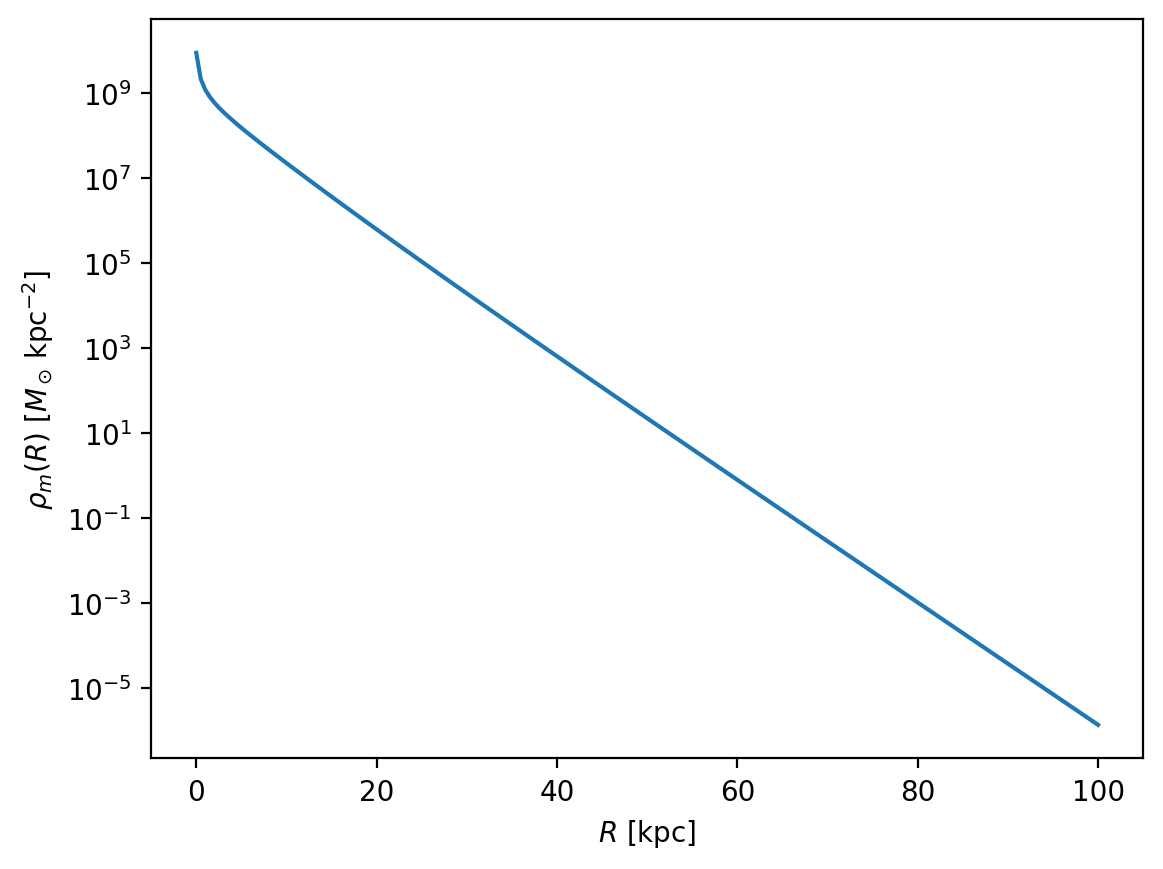

In [46]:
rho_m_dat = np.loadtxt('data/rho_m.txt',skiprows=1)
rho_m = interp1d(rho_m_dat.T[0],rho_m_dat.T[1])
plt.plot(rho_m_dat.T[0],rho_m(rho_m_dat.T[0]))
plt.yscale('log')
plt.xlabel('$R$ [kpc]')
plt.ylabel(r'$\rho_m(R)~[M_\odot\,{\rm kpc}^{-2}]$')
plt.show()

### Total SN$\nu$BDM flux

#### Geometry

For any supernova at **S**, its relation to the galactic center (**G**) and the boosted point (**B**) can be dipicted by the following figure

![alt text](images/scheme.png "scheme")

where $\ell$ is the SN$\nu$ traveling distance, $R$ the distance of SN to GC and $r$ the distance of boosted point to GC. By law of cosine we have
$$
r^2=\ell^2+R^2-2\ell R \cos\theta.
$$
Assuming the galaxy has a DM halo with maximum radius $r_{\rm max}$, we may require the DM number density $n_\chi(r)$ is non-zero only when $r\leq r_{\rm max}$.
Additionally, SN always happens at the stellar disc with matter density $\tilde{\rho}_m(R,z)$ where $R$ and $z$ are the radius and height in the cylindrical coordinate centering GC. For convinient, we may integrate over $z$ and obtain the areal density
$$
\rho_m(R)=\int dz \tilde{\rho}_m(R,z)
$$
with unit $M_\odot~{\rm kpc}^{-2}$.
We may further assume the disc is bounded within $R_{\rm max}$ and outside this radius the matter contribution is too small to be relevant.
From the triangular relation, we can set an upper bound for $\ell$ to be investigated by
$$
\ell_{\rm max} \leq r_{\rm max} + R_{\rm max}.
$$

Adopting spherical coordinate and let **S** in the origin, the SN$\nu$ spectrum on the sphere is
$$
\frac{dn_\nu}{dE_\nu}(\ell,E_\nu) = \sum_\beta \frac{L_{\nu_{\beta}}}{4\pi \ell^2 \langle E_{\nu_\beta}\rangle}f_{\nu_\beta}(E_{\nu_\beta})
$$
where $\beta$ indicates the neutrino flavor and
$$
f_{\nu_\beta}(E_{\nu_\beta}) = \frac{1}{F_2(\eta_\nu)}\frac{1}{T_{\nu_\beta}^3}\frac{E_{\nu_\beta}^2}{\exp(E_{\nu_\beta}/T_{\nu_\beta} -\eta_\nu)+1}
$$
and in general $\eta_\nu=3$ for all flavor $\beta$ and $F_2(\eta_\nu)\approx 18.96$. The spectrum has the unit MeV<sup>–1</sup> cm<sup>–2</sup> s<sup>–1</sup>.



#### Total BDM spectrum generated by a single SN
After propagating $d\ell$, the number of DM being upscattered is
$$
n_\chi\sigma_{\chi\nu}\tau\frac{dn_\nu}{dE_\nu} d\ell
$$
where $\tau\approx 10$ s is the duration of SN explosion.
Counting all the SN$\nu$ on the sphere with radius $\ell$, it becomes
$$
2\pi \ell^2 \sin\theta d\theta \times n_\chi\sigma_{\chi\nu}\tau\frac{dn_\nu}{dE_\nu} d\ell
$$
and has the unit MeV<sup>–1</sup>. Integrating over $\ell$, we obtain total nubmer of BDM w.r.t. to $E_\nu$,
$$
\frac{dN_\chi}{dE_\nu} = 2\pi\tau \int n_\chi\sigma_{\chi\nu}  \frac{dn_\nu}{dE_\nu} \ell^2 \sin\theta d\theta d\ell.
$$
To convert the above to w.r.t. BDM kinetic energy $T_\chi$, we make the following chain rule in the integrand
$$
\sigma_{\chi\nu}  \frac{dn_\nu}{dE_\nu}   \to \frac{d\sigma_{\chi\nu}}{d\Omega_c}  \frac{dn_\nu}{dE_\nu}\frac{dE_\nu}{dT_\chi} d\Omega_c
$$
where the subscript *c* indicates it is in CM frame. As we are interested in the total cross section, it will be much easier to perform in CM frame instead of lab frame. We can assume the differential cross section is isotropic in the CM frame and apply
$$
\frac{d\sigma_{\chi\nu}}{d\Omega_c} = \frac{\sigma_0(E_\nu)}{4\pi}.
$$
Note that given $T_\chi$, the required $E_\nu$ depends on the scattering angle $\theta_c$ in CM frame. Therefore
$$
\frac{d\sigma_{\chi\nu}}{d\Omega_c}  \frac{dn_\nu}{dE_\nu}\frac{dE_\nu}{dT_\chi} d\Omega_c = \frac{\sigma_0(E_\nu)}{2}\frac{dn_\nu(\theta_c)}{dE_\nu}\frac{dE_\nu(\theta_c)}{dT_\chi}\sin\theta_c d\theta_c
$$
which yields
$$
\frac{dN_\chi}{dT_\chi} =  \pi\tau \int d\theta_c \int d\theta \int d\ell ~\ell^2 \sin\theta\sin\theta_c  n_\chi(r(\ell))\sigma_0(E_\nu(\theta_c))\frac{dn_\nu(\ell,\theta_c)}{dE_\nu}\frac{dE_\nu(\theta_c)}{dT_\chi}
$$

If the galaxy is distant $d$ to Earth and and the CCSN rate for the galaxy is $R_{\rm CCSN}$, we have the associated BDM flux on the Earth
$$
\frac{d\Phi_\chi}{dT_\chi} = \frac{R_{\rm CCSN}}{4\pi d^2}\frac{dN_\chi}{dT_\chi}.
$$
The above has the dimension M<sup>–1</sup> L<sup>–2</sup> T<sup>–1</sup>.

##### BDM kinetic energy
The BDM kinetic energy $T_\chi$ is related to $E_\nu$ by
$$
T_\chi = \frac{E_\nu^2}{E_\nu + m_\chi/2}\cos^2\frac{\theta_c}{2}
$$
and
$$
E_\nu= \frac{T_\chi}{2c_2}\left(1+\sqrt{1+\frac{2c_2 m_\chi}{T_\chi}}\right),\quad
\frac{dE_\nu}{dT_\chi} = \frac{1}{2c_2}\left(1+\frac{T_\chi + c_2 m_\chi}{\sqrt{T_\chi (2 c_2 m_\chi+T_\chi)}}\right) = \frac{1}{2c_2}\left(1+\frac{1+c_2 m_\chi/T_\chi}{\sqrt{2c_2 m_\chi/T_\chi + 1}}\right)
$$
where $c_2\equiv\cos^2(\theta_c/2)$.

#### Total BDM flux at Earth generated by a distant galaxy

Given the areal density $\rho_m(R)$ and let the stellar mass to SN rate is $\eta_{\rm SN}$, with unit $M_\odot^{-1}$, we are able to calculate the total BDM spectrum averaged over the entire galactic mass distribution by
$$
\frac{d\bar{N}_\chi}{dT_\chi} =\frac{2\pi}{M_{\rm MW}} \int dR~ R \rho_m(R) \frac{dN_\chi(R)}{dT_\chi},
$$
where $M_{\rm MW}=2\pi\int dR~ R \rho_m(R) \approx 5.29\times 10^{10}M_\odot$ is the normalization constant.
Similarly, the associated BDM flux on Earth averaged overall all the entire galactic SN is
$$
\frac{d\bar{\Phi}_\chi}{dT_\chi} = \frac{R_{\rm CCSN}}{4\pi d^2}\frac{d\bar{N}_\chi}{dT_\chi}.
$$

In [4]:
def get_r(l,R,theta):
    """
    Get the distance between boosted point and GC
    
    Input
    ------
    l: SN neutrino propagation length, kpc
    R: Distance between SN and GC, kpc
    theta: polar angle, rad
    
    Output
    ------
    r: distance between boosted point and GC, kpc
    """
    return np.sqrt(l**2 + R**2 - 2*l*R*np.cos(theta))

def get_Ev(Tx,mx,theta_c):
    """
    Get the required incoming SN neutrino energy
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    theta_c: CM frame scattering angle, rad
    
    Output
    ------
    Ev: required incoming SN neutrino energy, MeV
    """
    c2 = np.cos(theta_c/2)**2
    return Tx*(1 + np.sqrt(1 + 2*c2*mx/Tx))/2/c2

def get_dEvdTx(Tx,mx,theta_c):
    """
    Get the slope of Ev vs. Tx: dEv/dTx
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    theta_c: CM frame scattering angle, rad
    
    Output
    ------
    dEv/dTx: dimensionless
    """
    c2 = np.cos(theta_c/2)**2
    x = mx/Tx
    return (1 + (1 + c2*x)/np.sqrt(2*c2*x + 1))/2/c2

def get_vx(Tx,mx):
    """
    Get the BDM velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    
    Output
    ------
    velocity: dimensionless, in the unit of c
    """
    return np.sqrt(Tx*(Tx + 2*mx))/(Tx + mx)

def sigma0(Ev,theta_c):
    """
    sigma_0 in CM frame
    
    Input
    ------
    Ev: incoming SN neutrino energy, MeV
    theta_c: the scattering angle in CM frame, rad
    
    Output
    ------
    cross section: cm^2
    """
    # this is energy-independent cross section
    return 1e-35

In [5]:
def nx(r,mx):
    """
    DM halo number density at r
    
    Input
    ------
    r: distance to GC, kpc
    mx: DM mass, MeV
    
    Output
    ------
    density: #/cm^3
    """
    rr=r/24.42
    return (184/mx)/(rr*(1 + rr)**2)

def snNuSpectrum(l,Ev,Lv=constant.Lv):
    """
    SN neutrino spectrum at distance l to the explosion site
    
    Input
    ------
    Ev: SN neutrino energy, MeV
    l: distance to the SN, kpc
    Lv: SN neutrino luminosity for single specie, total 6 (3 nu + 3 anti-nu)
    
    Output
    ------
    flux: #/Ev/cm^2/s
    """
    Lv = Lv*constant.erg2MeV
    l = l*constant.kpc2cm
    
    #Fermi-Dirac distribution
    def _fv(Ev,Tv):
        exponent = Ev/Tv - 3
        # setup a cutoff value when the exponent beyon the validatiy of float64
        if exponent <= 709.782:
            return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent)+1))
        else:
            return 0
    
    # distributions for nu_e and anti-nu_e
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # distributions for the rest 4 species
    nux_dist = _fv(Ev,6.26)/25
    
    L = Lv/(4*np.pi*l**2)
    return L*(nue_dist + nueb_dist + 4*nux_dist)

In [6]:
class dsnbBDMSpectrum(constant):
    """
    Class for evaluating energy spectrum of diffuse supernova neutrino background boosted dark matter
    """
    
    def __init__(self):
        pass
    
    @classmethod
    def __integ(cls,Tx,mx,R,l,theta,theta_c,rbound):
        """
        Integrand of dNx/dTx
        """
        r = get_r(l,R,theta)
        if rbound[0] <= r <= rbound[1]:
            Ev = get_Ev(Tx,mx,theta_c)
            dEvdTx = get_dEvdTx(Tx,mx,theta_c)
            vx = get_vx(Tx,mx) # correction factor to dEv/dTx
            integrand = l**2*np.sin(theta)*np.sin(theta_c)*nx(r,mx)*sigma0(Ev,theta_c)*snNuSpectrum(l,Ev,cls.Lv)*dEvdTx*vx
            return integrand
        else:
            return 0
        
    @classmethod
    def __integAvg(cls,Tx,mx,R,l,theta,theta_c,rbound):
        """
        Integrand of dNx_bar/dTx
        """
        r = get_r(l,R,theta)
        if rbound[0] <= r <= rbound[1]:
            Ev = get_Ev(Tx,mx,theta_c)
            dEvdTx = get_dEvdTx(Tx,mx,theta_c)
            vx = get_vx(Tx,mx) # correction factor to dEv/dTx
            integrand = R*rho_m(R)*l**2*np.sin(theta)*np.sin(theta_c)*nx(r,mx)*sigma0(Ev,theta_c)*snNuSpectrum(l,Ev,cls.Lv)*dEvdTx*vx
            return integrand
        else:
            return 0
        
    @classmethod
    def totalSpectrum(cls,Tx,mx,R,rbound=[1e-5,50],Rmax=30,tau=10,neval=5000):
        """
        Evaluating BDM spectrum dNx/dTx from a specific SN at R distant
        to GC in the stellar disc
        
        Input
        ------
        Tx: DM kinetic energy, MeV
        mx: DM mass, MeV
        R: SN distance to GC, kpc
        rbound: list of the lower and upper bounds of the halo radius to
                be considered, default [1e-5,50] kpc
        Rmax: Maximum radius of the stellar disc, default 30 kpc
        tau: Duration of the SN explosion, default 10 s
        neval: Number of evaluation points in vegas, default 5000
        
        Output
        ------
        dNx/dTx: #/MeV
        """
        # initializing vegas
        lmax = Rmax + rbound[1]
        integ = vegas.Integrator([[0,lmax],[0,np.pi],[0,np.pi]]) #(l,theta,theta_c)
        int_result = integ(lambda x: cls.__integ(Tx=Tx,mx=mx,R=R,l=x[0],theta=x[1],theta_c=x[2],rbound=rbound),nitn=10,neval=neval).mean
        dNxdTx = np.pi*tau*int_result*cls.kpc2cm**3
        return dNxdTx
    
    @classmethod
    def totalSpectrumAverage(cls,Tx,mx,rbound=[1e-5,50],Rmax=30,tau=10,neval=5000):
        """
        Evaluating averaged BDM spectrum dNx_bar/dTx over the entire SN
        contributions from the stellar disc
        
        Input
        ------
        Tx: DM kinetic energy, MeV
        mx: DM mass, MeV
        rbound: list of the lower and upper bounds of the halo radius to
                be considered, default [1e-5,50] kpc
        Rmax: Maximum radius of the stellar disc, default 30 kpc
        tau: Duration of the SN explosion, default 10 s
        neval: Number of evaluation points in vegas, default 5000
        
        Output
        ------
        dNx_bar/dTx: #/MeV
        """
        lmax = Rmax + rbound[1]
        integ = vegas.Integrator([[0,Rmax],[0,lmax],[0,np.pi],[0,np.pi]]) #(R,l,theta,theta_c)
        int_result = integ(lambda x: cls.__integAvg(Tx=Tx,mx=mx,R=x[0],l=x[1],theta=x[2],theta_c=x[3],rbound=rbound),nitn=10,neval=neval).mean
        dNxdTx_bar = 2*np.pi**2*tau*int_result*cls.kpc2cm**3/cls.Mmw
        return dNxdTx_bar

### The stellar mass function
The mass function $\phi(M)$ is given by
$$
\phi(M) = \phi_0 \ln(10) (10^{M-M_c})^{1+\alpha}\exp(-10^{M-M_c})
$$
where $M=\log_{10} M_*/M_\odot$ and $M_*$ the galaxy mass, $M_c$ the characteristic mass in log<sub>10</sub> unit, $\phi_0$ the normalization and $\alpha$ determines the slope for fainter and lower mass galaxies.
The parameters $(M_c,\phi_0,\alpha)$ are fitted by the observational at different redshift $z$.
The mass function $\phi(M)$ has the unit Mpc<sup>–3</sup> M<sup>–1</sup>.
Let $\log\equiv\log_{10}$ and take $\log$ on $\phi(M)$ yields
$$
\log \phi(M) = \log \phi_0 + \log\ln 10 + (M-M_c)(1+\alpha) - 10^{M-M_c}\log e.
$$
Thus, the galaxy number density at given redshift $z$ is
$$
\phi_T(z) = \int_{M_{*,{\rm min}}}^{M_{*,{\rm max}}}\phi(M,z)dM
$$

In [62]:
def ln_phi(alpha,Mc,phi0,M):
    log_phi0 = np.log10(phi0) - 4
    logln10 = 0.362216
    #ln10 = 1 #2.30259
    logE = 0.43429
    return log_phi0 + logln10 + (M - Mc)*(1 + alpha) - 10**(M - Mc)*logE

def ln_phiz(M,z):
    if z <= 0.7:
        return ln_phi(-1.11,11.22,18.2,M)
    elif 0.7 < z <= 1:
        return ln_phi(-1.27,11.37,11.0,M)
    elif 1 < z <= 1.4:
        return ln_phi(-1.28,11.26,6.2,M)
    elif 1.4 < z <= 1.8:
        return ln_phi(-1.31,11.25,4.3,M)
    elif 1.8 < z <= 2.2:
        return ln_phi(-1.34,11.22,3.1,M)
    elif 2.2 < z <= 2.6:
        return ln_phi(-1.38,11.16,2.4,M)
    elif 2.6 < z <= 3:
        return ln_phi(-1.41,11.09,1.9,M)
    elif 3 < z <= 3.5:
        return ln_phi(-1.45,10.97,1.5,M)
    elif 3.5 < z <= 4:
        return ln_phi(-1.49,10.81,1.1,M)
    elif 4 < z <= 4.5:
        return ln_phi(-1.53,10.44,3.0,M)
    elif 4.5 < z <= 5.5:
        return ln_phi(-1.67,10.47,1.3,M)
    elif 5.5 < z <= 6.5:
        return ln_phi(-1.93,10.3,0.3,M)
    elif z > 6:
        return ln_phi(-2.05,10.42,0.1,M)
    
def phi_T(z,Mrange=[6,12]):
    M1,M2 = Mrange
    return quad(lambda M: 10**ln_phiz(M,z),M1,M2)[0]

D_C_dat = np.loadtxt('data/D_C.txt',skiprows=2)
Dc = interp1d(D_C_dat.T[0],D_C_dat.T[1]*constant.D_H0)

#def Dc(z):
#    a = 1/(1 + z)
#    denominator = a/(1 - a) + 0.2278 + 0.2070*(1 - a)/(0.785 + a) - 0.0158*(1 - a)/(0.312 + a)**2
#    return constant.D_H0/denominator

def E(z):
    y = (1 + z)
    return np.sqrt(constant.Omega_0m*y**3 + constant.Omega_0L)

def dComovingVolume(z):
    return 4*np.pi*constant.D_H0*Dc(z)**2/E(z)

def rhoDotSFR(z):
    a,b,c = 3.4,-0.3,-3.5
    z1,z2,eta = 1,4,-10
    B = (1 + z1)**(1 - a/b)
    C = (1 + z1)**((b - a)/c)*(1 + z2)**(1 - b/c)
    Z = 1 + z
    return 0.0178*(Z**(a*eta) + (Z/B)**(b*eta) + (Z/C)**(c*eta))**(1/eta)

def R_CCSN(z,Mgal,R0_MW = 0.012):
    rhoDotSFR0 = 0.01779
    return R0_MW*rhoDotSFR(z)*Mgal/constant.Mmw/rhoDotSFR0

def dEff(z):
    return constant.D_H0/E(z)

# Load BDM spectrum data and interpolate, mx=1MeV, sigma_xv = 1e-35 cm^2, Tx = [1,200] MeV
# GC
dndt_gc_dat = np.loadtxt('data/dNxdTx_mx1MeV_1e-35cm2_GC.txt',skiprows=1)
dNxdTx_GC = interp1d(dndt_gc_dat.T[0],dndt_gc_dat.T[1])
# Average
dndt_avg_dat = np.loadtxt('data/dNxdTx_mx1MeV_1e-35cm2_Average.txt',skiprows=1)
dNxdTx_Avg = interp1d(dndt_avg_dat.T[0],dndt_avg_dat.T[1])

### DSNB BDM

We follow `arXiv:astro-ph/0410061` to derive the DSNB BDM flux.

#### At redshift $z$
Since each distant galaxy can be considered as a point, mimic DSNB calculation, the number density of BDM, whose energy is in the interval $T_\chi\sim T_\chi + dT_\chi$ emiited from the galaxy $G$ in the redshift interval $z\sim z+dz$, is given by
$$
dn_\chi (T_\chi) = R_{{\rm SN},G}(z) (1+z)^3 dt \frac{dN_\chi(T_\chi^\prime)}{dT_\chi^\prime}{dT_\chi^\prime}(1+z)^{-3}
$$
where $T_\chi^\prime=(1+z)T_\chi$ is the BDM kinetic energy at $z$, which is now observed as $T_\chi$, $R_{{\rm SN}, G}(z)$ the SN rate of galaxy $G$ per comoving volume at $z$ and $dN_\chi/dT_\chi^\prime$ is the BDM energy spectrum due to any SN in $G$. The factors $(1+z)^3$ and $(1+z)^{-3}$ are associated with the comoving volume and expansion of the Universe, respectively. The dimension of the above is
$$
[dn_\chi] = [{\rm L}^{-3}~{\rm T}^{-1}]\times [{\rm T}] \times  [{\rm energy}^{-1}] \times  [{\rm energy}] =  [{\rm L}^{-3}] 
$$
which is exactly the dimension of number density.

#### Integrating over $z$
We may associate $dt$ with $z$ by
$$
\frac{dz}{dt} = H_0(1+z) E(z)
$$
where $H_0$ is the Hubble constant at present day and $E(z)=\sqrt{\Omega_m(1+z)^3+\Omega_\Lambda}$ with $\Omega_m=0.3$ and $\Omega_\Lambda=0.7$. Given BDM velocity at $z$ is $v_\chi(z) c$ where
$$
v_\chi(z)= \frac{\sqrt{T_\chi^\prime (T_\chi^\prime + 2m_\chi)}}{T_\chi^\prime + m_\chi}=\frac{\sqrt{T_\chi [T_\chi + 2m_\chi/(1+z)]}}{T_\chi + m_\chi/(1+z)}.
$$
The differential number flux of BDM is given by
$$
\frac{d\Phi_\chi}{dT_\chi} = \frac{c}{H_0} \int_0^{z_{\rm max}}dz~E(z)v_\chi(z)R_{{\rm SN},G}(z)\frac{dN_\chi(T_\chi^\prime)}{dT_\chi^\prime}
$$
where $D_{H_0}=c/H_0\approx 4280$ Mpc. The above yields
$$
[{\rm L}]\times[{\rm L}^{-3}\,{\rm T}^{-1}]\times[{\rm energy}^{-1}] = [{\rm energy}^{-1}~{\rm L}^{-2}~{\rm T}^{-1}]
$$
which is consistant with the dimension of flux.

#### The SN rate per comoving volume

Given $R_{\rm SN,0}$ is the SN rate of our Milky Way with unit yr<sup>–1</sup>. We can scale it to arbitrary number density of galaxy $G$ with stellar mass $M_G$ in $ M_G+dM_G$ by
$$
R_{{\rm SN},G}(z)= \int dM_G~\phi(M_G,z) R_{\rm SN,0}\frac{M_G}{M_{\rm MW}} \frac{\dot{\rho}_*(z)}{\dot{\rho}_*(0)}
$$
where $\phi(M_G,z)$ is the number density of galaxy with stellar mass in $ M_G+dM_G$ and commonly expressed in the unit of ${\rm Mpc}^{-3}~M_G^{-1}$. The star formation rate at $z$ is
$$
\dot{\rho}_*(z)=\dot{\rho}_0\left[(1+z)^{a\eta}+\left(\frac{1+z}{B}\right)^{b\eta}+\left(\frac{1+z}{C}\right)^{c\eta}\right]^{1/\eta}
$$
where $\dot{\rho}_0=0.0178M_\odot~{\rm yr}^{-1}~{\rm Mpc}^{-3}$ and $(a,b,c,\eta)=(3.4,-0.3,-3.5,-10)$. The redshif break constants are defined as $B=(1+z_1)^{1-a/b}$ and $C=(1+z_1)^{(b-a)/c}(1+z_2)^{1-b/c}$.

Given a MW size galaxy, we assume the total DM mass of that galaxy is $M_{\rm DM}=a M_{\rm MW}$ and $a>1$ is some constant. The BDM energy spectrum is $ dN_{\chi,0}/dT_\chi$. Assuming $a$ is universal, the BDM energy spectrum produced by a galaxy $G$ with stellar mass $M_G$ can be scaled as
$$
\frac{dN_{\chi,G}}{dT_\chi} = \frac{dN_{\chi,0}}{dT_\chi} \frac{a M_G}{a M_{\rm MW}}=  \frac{dN_{\chi,0}}{dT_\chi} \frac{ M_G}{ M_{\rm MW}}.
$$
Thus, we may rewrite the BDM flux in terms of this modification
\begin{align}
\frac{d\Phi_\chi}{dT_\chi} &= D_{H_0}\int_0^{z_{\rm max}}dz \int_{M_{\rm min}}^{M_{\rm max} }dM_G~ E(z)v_\chi(z) \phi(M_G,z) R_{\rm SN,0}\left(\frac{M_G}{M_{\rm MW}}\right)^2 \frac{\dot{\rho}_*(z)}{\dot{\rho}_*(0)} \frac{dN_{\chi,0}(T_\chi^\prime)}{dT_\chi^\prime} \\
& =\frac{D_{H_0}R_{{\rm SN},0}}{M_W^2 \dot{\rho}_*(0)} \int_0^{z_{\rm max}}dz \int_{M_{\rm min}}^{M_{\rm max} }dM_G~M_G^2 \phi(M_G,z)  E(z)v_\chi(z) \dot{\rho}_*(z) \frac{dN_{\chi,0}(T_\chi^\prime)}{dT_\chi^\prime}. 
\end{align}
One can carefully examine the dimension of  second line in the above equation and it does yield ${\rm MeV}^{-1}~{\rm Mpc}^{-2}\,{\rm yr}^{-1}$.

In [90]:
def integrand_GC(z,MG,Tx,mx):
    Txp = (1 + z)*Tx 
    if Txp < 200:
        return (10**MG)**2*10**ln_phiz(MG,z)*E(z)*rhoDotSFR(z)*dNxdTx_GC(Txp)/mx*get_vx(Txp,mx)
    else:
        return 0
    
def integrand_Avg(z,MG,Tx,mx):
    Txp = (1 + z)*Tx 
    if Txp < 200:
        return (10**MG)**2*10**ln_phiz(MG,z)*E(z)*rhoDotSFR(z)*dNxdTx_Avg(Txp)/mx*get_vx(Txp,mx)
    else:
        return 0

def dPhiX_dTx_GC(Tx,mx,neval=5000):
    integ_GC = vegas.Integrator([[0,8],[6,12]]) #[z,log10(MG)]
    return integ_GC(lambda x: integrand_GC(x[0],x[1],Tx,mx)).mean

def dPhiX_dTx_Avg(Tx,mx,neval=5000):
    integ_Avg = vegas.Integrator([[0,8],[6,12]]) #[z,log10(MG)]
    return integ_Avg(lambda x: integrand_Avg(x[0],x[1],Tx,mx)).mean

factor = constant.D_H0*0.017/constant.Mmw*rhoDotSFR(0)/1e6/constant.kpc2cm**2/constant.year2Seconds

In [84]:
TxList = np.linspace(5,100,40)
# GC
pool1 = mp.Pool(processes=40)
dPhi_X_GC_mx1 = pool.map(partial(dPhiX_dTx_GC,mx=1),TxList)
dPhi_X_GC_mx01 = pool.map(partial(dPhiX_dTx_GC,mx=0.1),TxList)
# Average
pool2 = mp.Pool(processes=40)
dPhi_X_Avg_mx1 = pool2.map(partial(dPhiX_dTx_Avg,mx=1),TxList)
dPhi_X_Avg_mx01 = pool2.map(partial(dPhiX_dTx_Avg,mx=0.1),TxList)

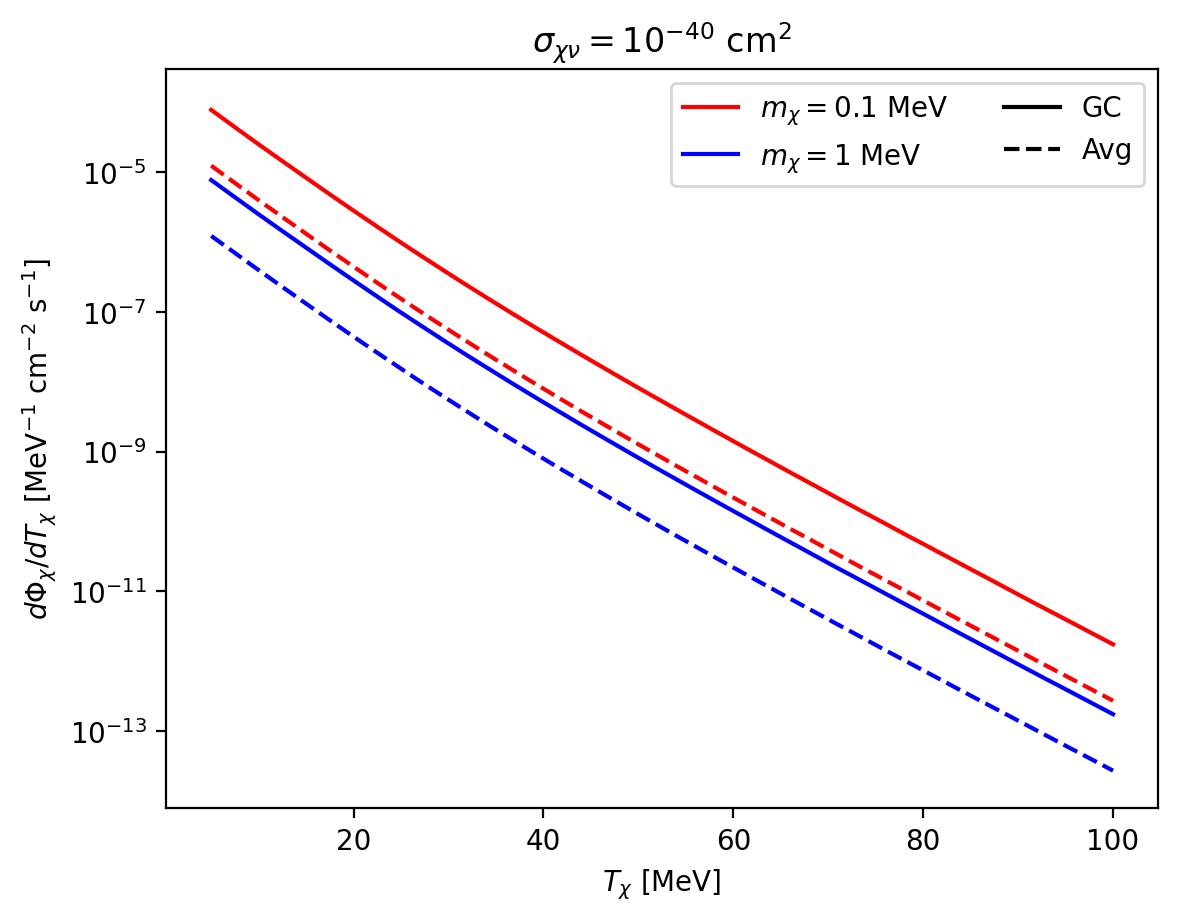

In [111]:
plt.plot(TxList,np.asarray(dPhi_X_GC_mx01)*factor*1e-5,'-r',label=r'$m_\chi=0.1$ MeV')
plt.plot(TxList,np.asarray(dPhi_X_GC_mx1)*factor*1e-5,'-b',label=r'$m_\chi=1$ MeV')
plt.plot(TxList,np.asarray(dPhi_X_Avg_mx01)*factor*1e-5,'--r')
plt.plot(TxList,np.asarray(dPhi_X_Avg_mx1)*factor*1e-5,'--b')
plt.plot([20,25],[10,10],color='black',label='GC')
plt.plot([20,25],[10,10],'--',color='black',label='Avg')

plt.legend(ncol=2)
plt.title(r'$\sigma_{\chi\nu}=10^{-40}~{\rm cm}^2$')
plt.yscale('log')
plt.ylim(8e-15,3e-4)
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.savefig('figures/DSNB_BDM.pdf',bbox_inches='tight')

In [209]:
ln_phiz_M6 = []
ln_phiz_M8 = []
ln_phiz_M10 = []
ln_phiz_M12 = []
for z in zlist:
    ln_phiz_M6.append(ln_phiz(6,z))
    ln_phiz_M8.append(ln_phiz(8,z))
    ln_phiz_M10.append(ln_phiz(10,z))
    ln_phiz_M12.append(ln_phiz(12,z))

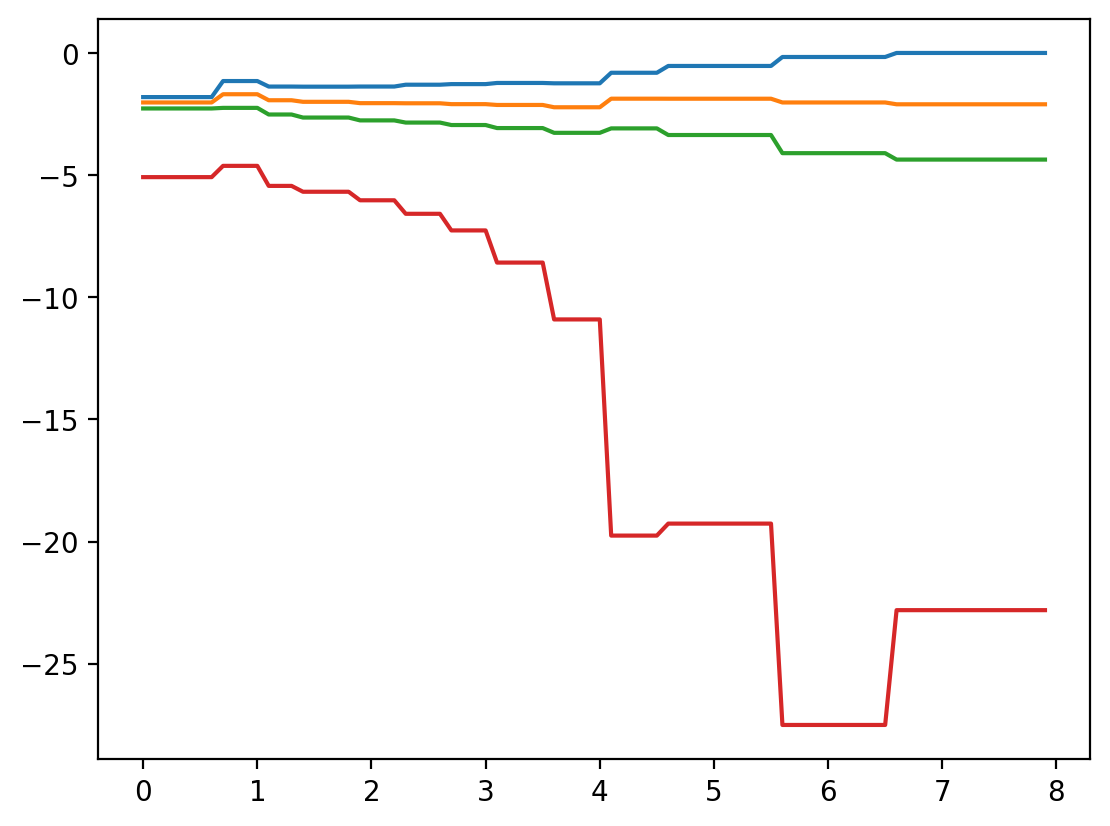

In [210]:
plt.plot(zlist,ln_phiz_M6)
plt.plot(zlist,ln_phiz_M8)
plt.plot(zlist,ln_phiz_M10)
plt.plot(zlist,ln_phiz_M12)

In [194]:
phis = interp1d([0.45,0.85,1.2,1.6,2,2.4,2.8,3.25,3.75,4.25,5,6,6.75],[18.2,11,6.2,4.3,3.1,2.4,1.9,1.5,1.1,3,1.3,0.3,0.1],bounds_error=False)

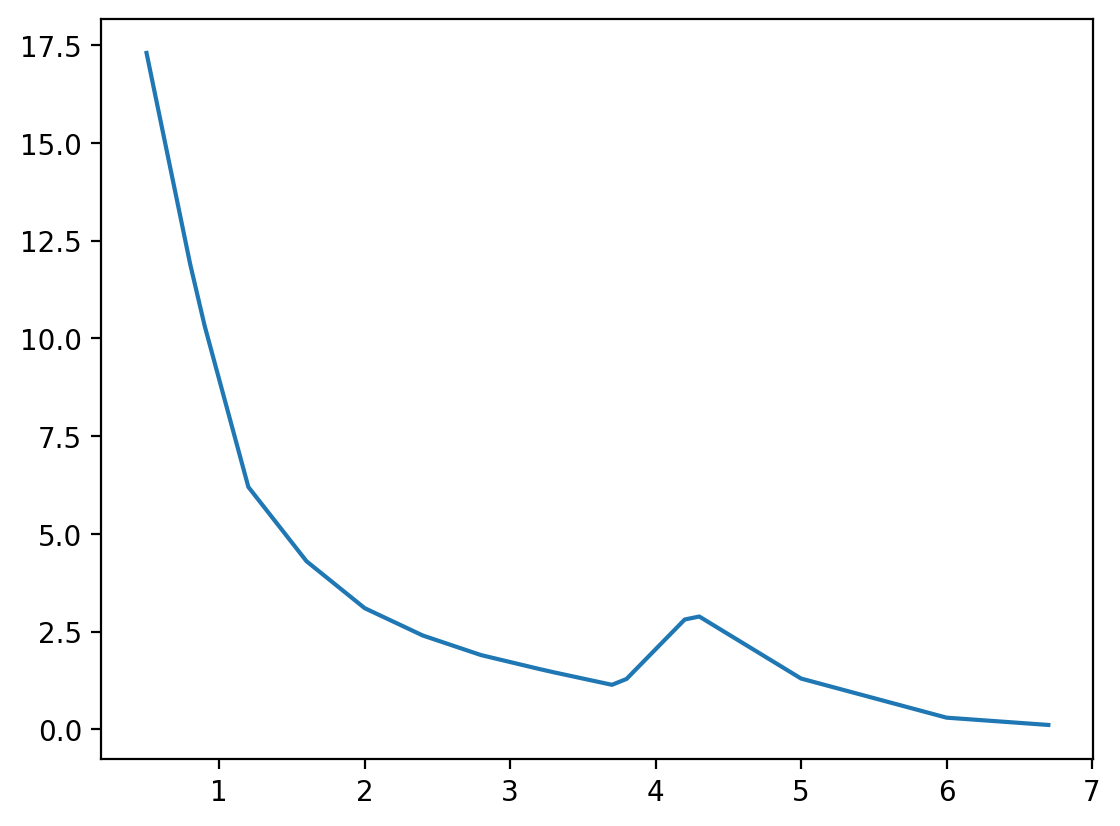

In [195]:
plt.plot(zlist,phis(zlist))

Text(0, 0.5, '$R_{\\rm SN}(z)$ [yr$^{-1}$]')

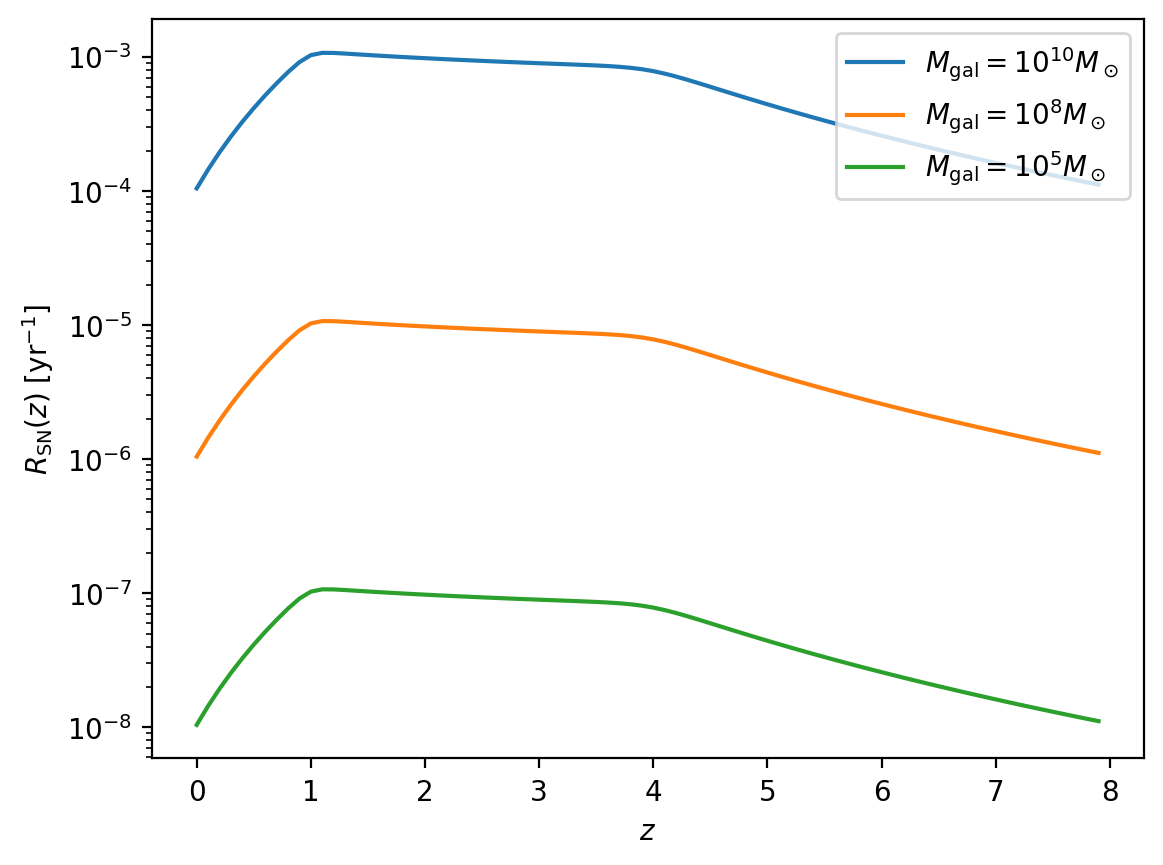

In [150]:
zlist = np.arange(0,8,0.1)
plt.plot(zlist,R_CCSN(zlist,1e10),label=r'$M_{\rm gal} = 10^{10}M_\odot$')
plt.plot(zlist,R_CCSN(zlist,1e8),label=r'$M_{\rm gal} = 10^8M_\odot$')
plt.plot(zlist,R_CCSN(zlist,1e6),label=r'$M_{\rm gal} = 10^{5}M_\odot$')
plt.legend()
plt.yscale('log')
plt.xlabel('$z$')
plt.ylabel(r'$R_{\rm SN}(z)$ [yr$^{-1}$]')

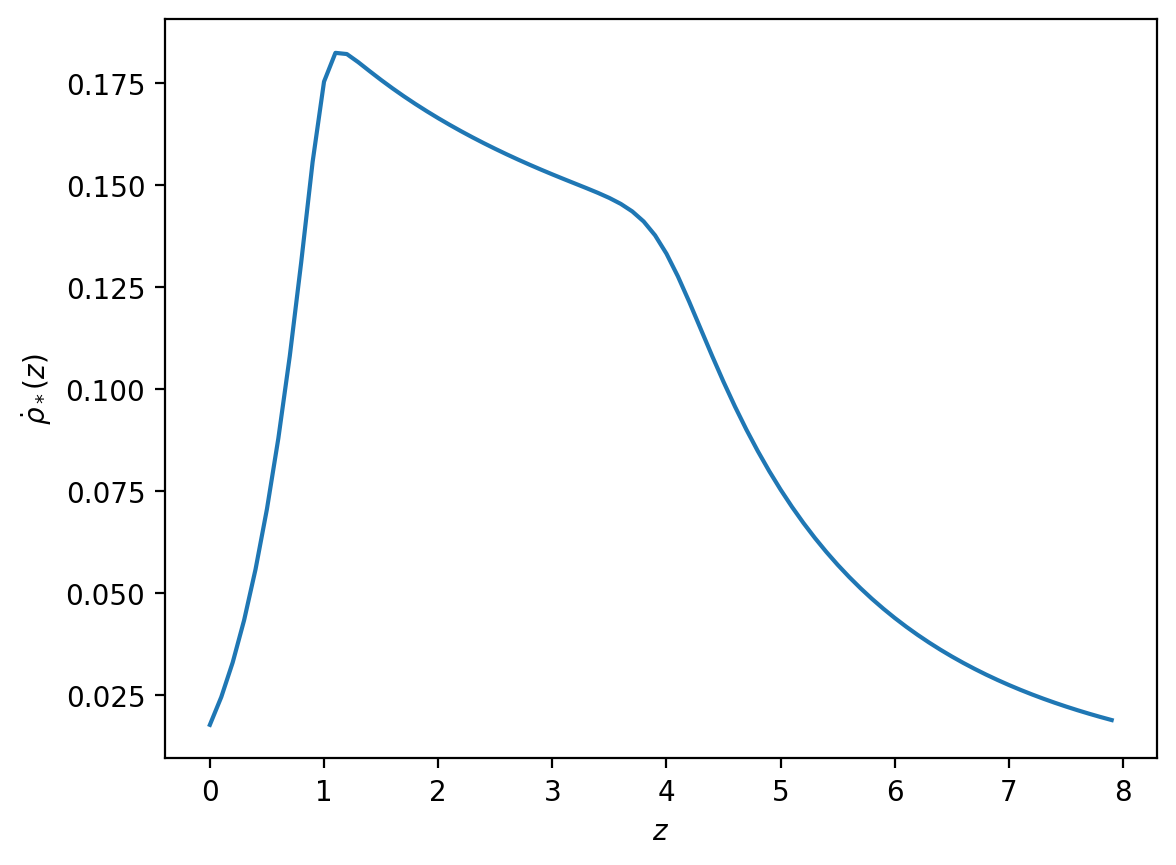

In [175]:
plt.plot(zlist,rhoDotSFR(zlist))
plt.xlabel(r'$z$')
plt.ylabel(r'$\dot{\rho}_*(z)$')
plt.savefig('figures/rhodot_SFR.pdf',bbox_inches='tight')

In [206]:
def RSN_z(z):
    integ = vegas.Integrator([[6,12]]) #(M,z)
    return np.log10(integ(lambda x: 10**(ln_phiz(x[0],z))*R_CCSN(z,10**x[0])*dComovingVolume(z),nitn=10,neval=5000).mean)

In [162]:
pool = mp.Pool(processes=40)
#NvsR = pool.map(lambda R: dsnbBDM.totalSpectrum(10,0.1,R,rbound=[1e-5,50],Rmax=30,tau=10,neval=5000),rList.tolist())
rsn = pool.map(RSN_z,zlist)
rsn = np.asarray(rsn)

/tmp/ipykernel_56/3165428732.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  denominator = a/(1 - a) + 0.2278 + 0.2070*(1 - a)/(0.785 + a) - 0.0158*(1 - a)/(0.312 + a)**2
/tmp/ipykernel_56/271750849.py:3: RuntimeWarning: divide by zero encountered in log10
  return np.log10(integ(lambda x: 10**(ln_phiz(x[0],z))*R_CCSN(z,10**x[0])*dComovingVolume(z),nitn=10,neval=5000).mean)


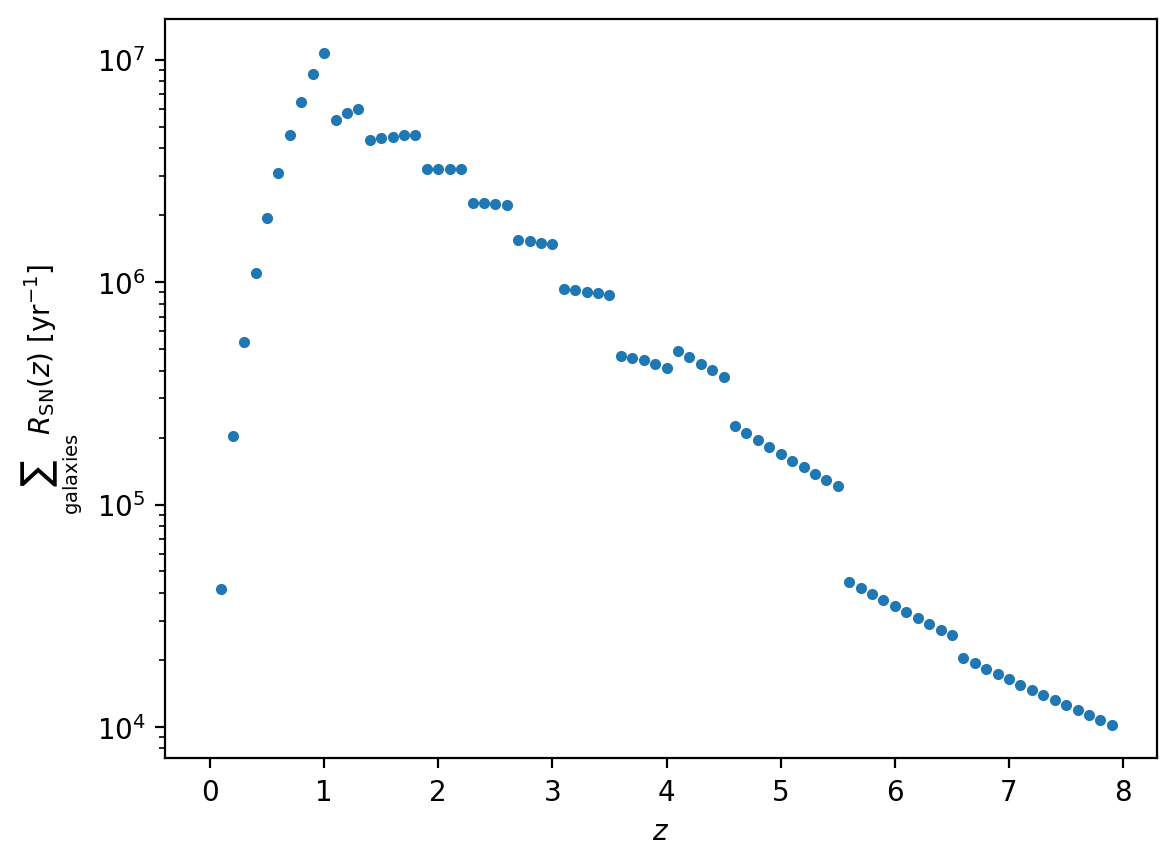

In [173]:
plt.plot(zlist,10**rsn,'.')
plt.xlabel(r'$z$')
plt.ylabel(r'$\sum_{\rm galaxies} R_{\rm SN}(z)$ [yr$^{-1}$]')
plt.yscale('log')
plt.savefig('figures/R_SN_v_z.pdf',bbox_inches='tight')

In [320]:
integ = vegas.Integrator([[6,13],[0,8]]) #(M,z)
def dnde_dsnb(Ev):
    return integ(lambda x: 10**(ln_phiz(x[0],x[1]))*R_CCSN(x[1],10**x[0])*dEff(x[1])*dsnbSpectrum(Ev*(1+x[1])),nitn=10,neval=5000).mean

In [323]:
EvList = np.linspace(0,100,40)
pool = mp.Pool(processes=40)
#NvsR = pool.map(lambda R: dsnbBDM.totalSpectrum(10,0.1,R,rbound=[1e-5,50],Rmax=30,tau=10,neval=5000),rList.tolist())
dsnb_spec = pool.map(dnde_dsnb,EvList)
dsnb_spec = np.asarray(dsnb_spec)

(0.0001, 10)

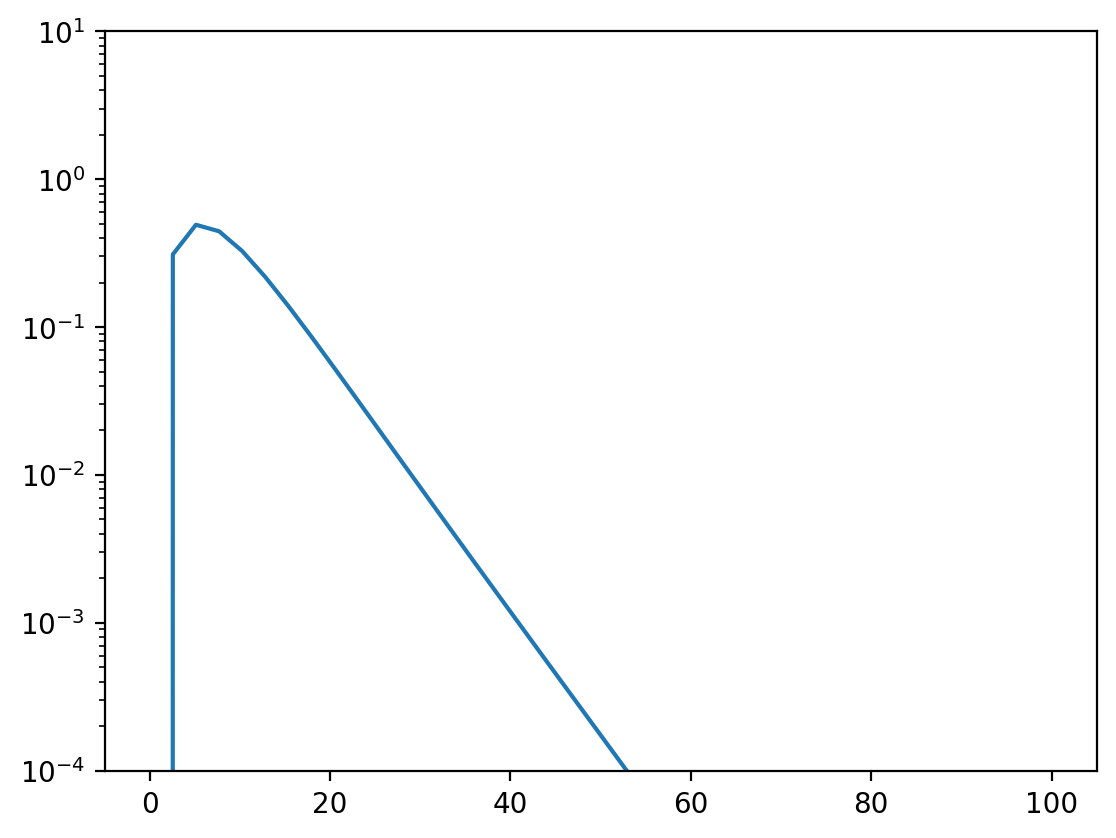

In [324]:
plt.plot(EvList,dsnb_spec/1e6/constant.kpc2cm**2/constant.year2Seconds)
#plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,10)
#plt.xlim(0,60)
#plt.savefig('figures/compare_Fig5_YuAn.pdf',bbox_inches='tight')

In [328]:
6*constant.Lv*constant.erg2MeV

1.8724527389999998e+58

(0.0001, 10)

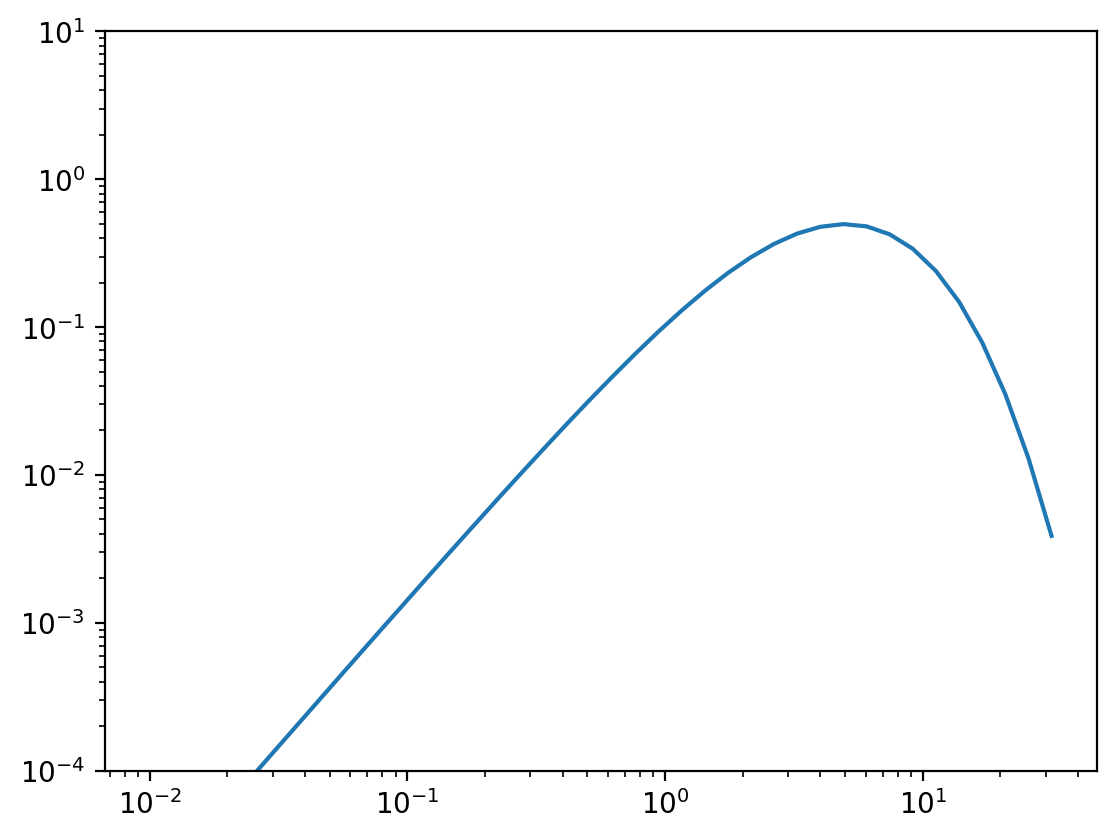

In [306]:
plt.plot(EvList,dsnb_spec/1e6/constant.kpc2cm**2/constant.year2Seconds)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,10)

In [297]:
np.max(dsnb_spec/1e6/constant.kpc2cm**2/constant.year2Seconds)

0.479392944038396

In [100]:
pool = mp.Pool(processes=40)
#NvsR = pool.map(lambda R: dsnbBDM.totalSpectrum(10,0.1,R,rbound=[1e-5,50],Rmax=30,tau=10,neval=5000),rList.tolist())
phit = pool.map(phi_T,zlist)
phit = np.asarray(phit)

Text(0, 0.5, '$\\log \\phi_T$ [Mpc$^{-3}$]')

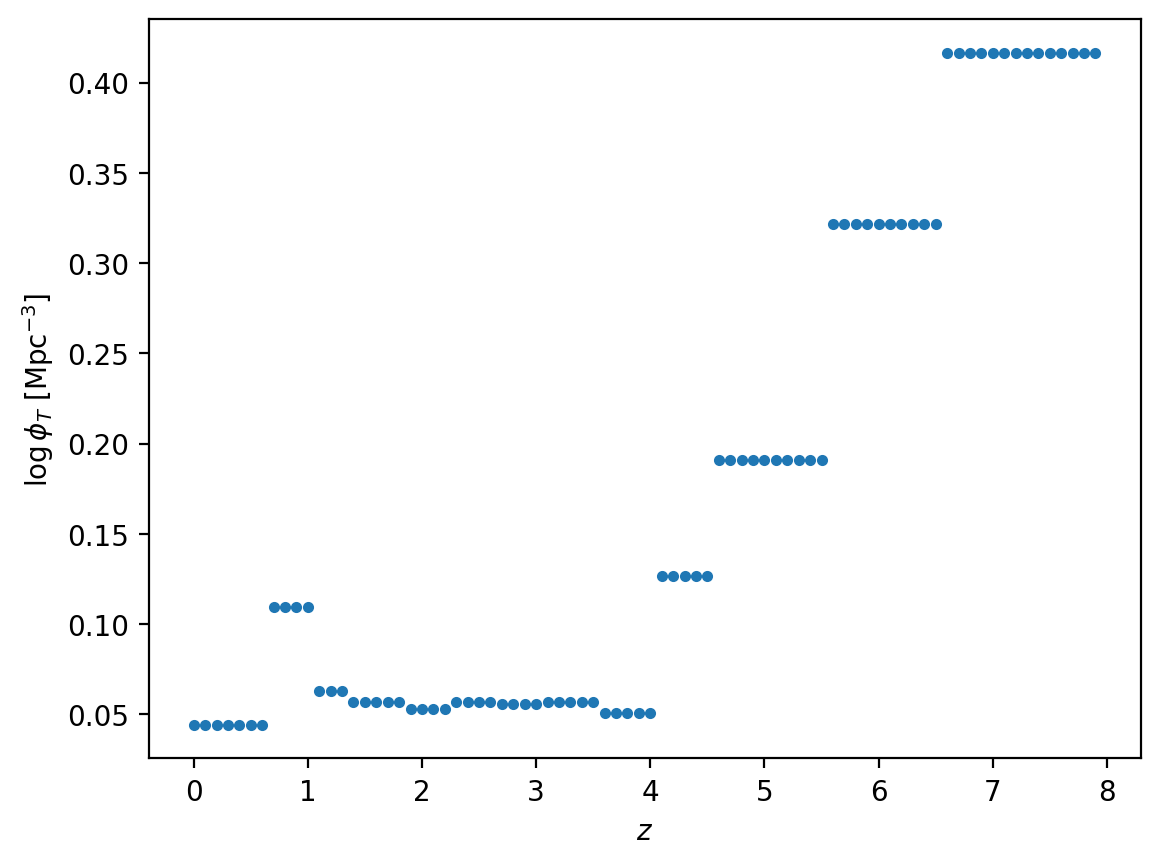

In [101]:
plt.plot(zlist,phit,'.')
#plt.yscale('log')
#plt.ylim(0.1,10)
plt.xlabel(r'$z$')
plt.ylabel(r'$\log \phi_T$ [Mpc$^{-3}$]')
#plt.savefig('figures/phi_T.pdf',bbox_inches='tight')

In [92]:
phit

array([0.0442525 , 0.0442525 , 0.0442525 , 0.0442525 , 0.0442525 ,
       0.0442525 , 0.0442525 , 0.10969022, 0.10969022, 0.10969022,
       0.10969022, 0.06296429, 0.06296429, 0.06296429, 0.05700824,
       0.05700824, 0.05700824, 0.05700824, 0.05700824, 0.0530399 ,
       0.0530399 , 0.0530399 , 0.0530399 , 0.05679451, 0.05679451,
       0.05679451, 0.05679451, 0.05590635, 0.05590635, 0.05590635,
       0.05590635, 0.05692358, 0.05692358, 0.05692358, 0.05692358,
       0.05692358, 0.0506724 , 0.0506724 , 0.0506724 , 0.0506724 ,
       0.0506724 , 0.12659594, 0.12659594, 0.12659594, 0.12659594,
       0.12659594, 0.1912527 , 0.1912527 , 0.1912527 , 0.1912527 ,
       0.1912527 , 0.1912527 , 0.1912527 , 0.1912527 , 0.1912527 ,
       0.1912527 , 0.32160895, 0.32160895, 0.32160895, 0.32160895,
       0.32160895, 0.32160895, 0.32160895, 0.32160895, 0.32160895,
       0.32160895, 0.4165518 , 0.4165518 , 0.4165518 , 0.4165518 ,
       0.4165518 , 0.4165518 , 0.4165518 , 0.4165518 , 0.41655

In [55]:
285000000/1e6

285.0

Text(0.5, 1.0, '$(m_\\chi,T_\\chi)=(0.1,10)$ MeV')

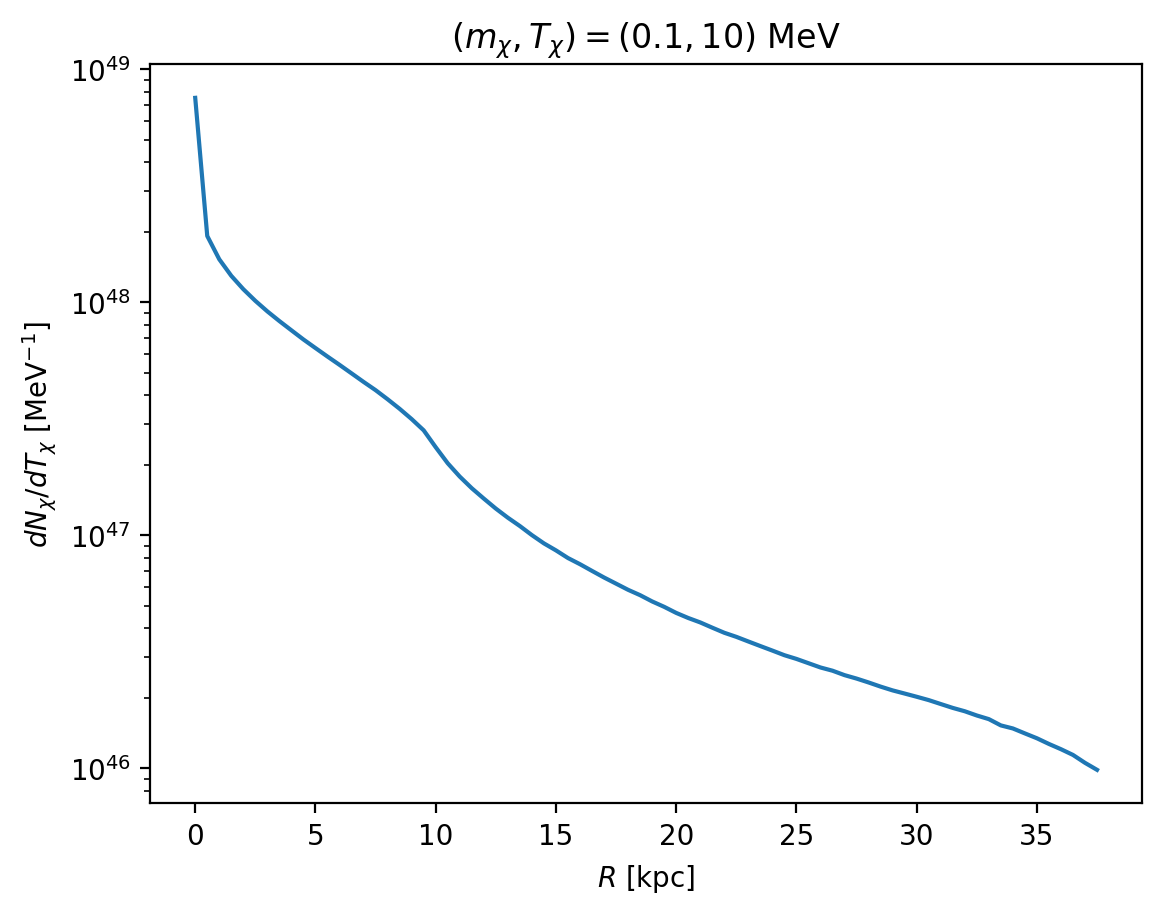

In [248]:
plt.plot(rList,NvsR)
plt.yscale('log')
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$dN_\chi/dT_\chi$ [MeV$^{-1}$]')
plt.title(r'$(m_\chi,T_\chi)=(0.1,10)$ MeV')

In [56]:
TxList=np.linspace(1,200,120)
def testmpTx(Tx):
    single_GC = dsnbBDMSpectrum.totalSpectrum(Tx,1,0,rbound=[1e-5,100],Rmax=30,tau=10,neval=5000)
    average_MW = dsnbBDMSpectrum.totalSpectrumAverage(Tx,1,rbound=[1e-5,100],Rmax=30,tau=10,neval=5000)
    return single_GC,average_MW
pool = mp.Pool(processes=40)
#NvsR = pool.map(lambda R: dsnbBDM.totalSpectrum(10,0.1,R,rbound=[1e-5,50],Rmax=30,tau=10,neval=5000),rList.tolist())
Nx = pool.map(testmpTx,TxList)

In [61]:
np.savetxt('data/dNxdTx_mx1MeV_1e-35cm2_GC.txt',np.vstack((TxList,Nx.T[0])).T,fmt='%.2f       %.5e',header='Tx [MeV]   dNx/dTx [1/MeV]',comments='')

Text(0.5, 1.0, '$m_\\chi=1$ MeV and $r_{\\rm max}=100$ kpc')

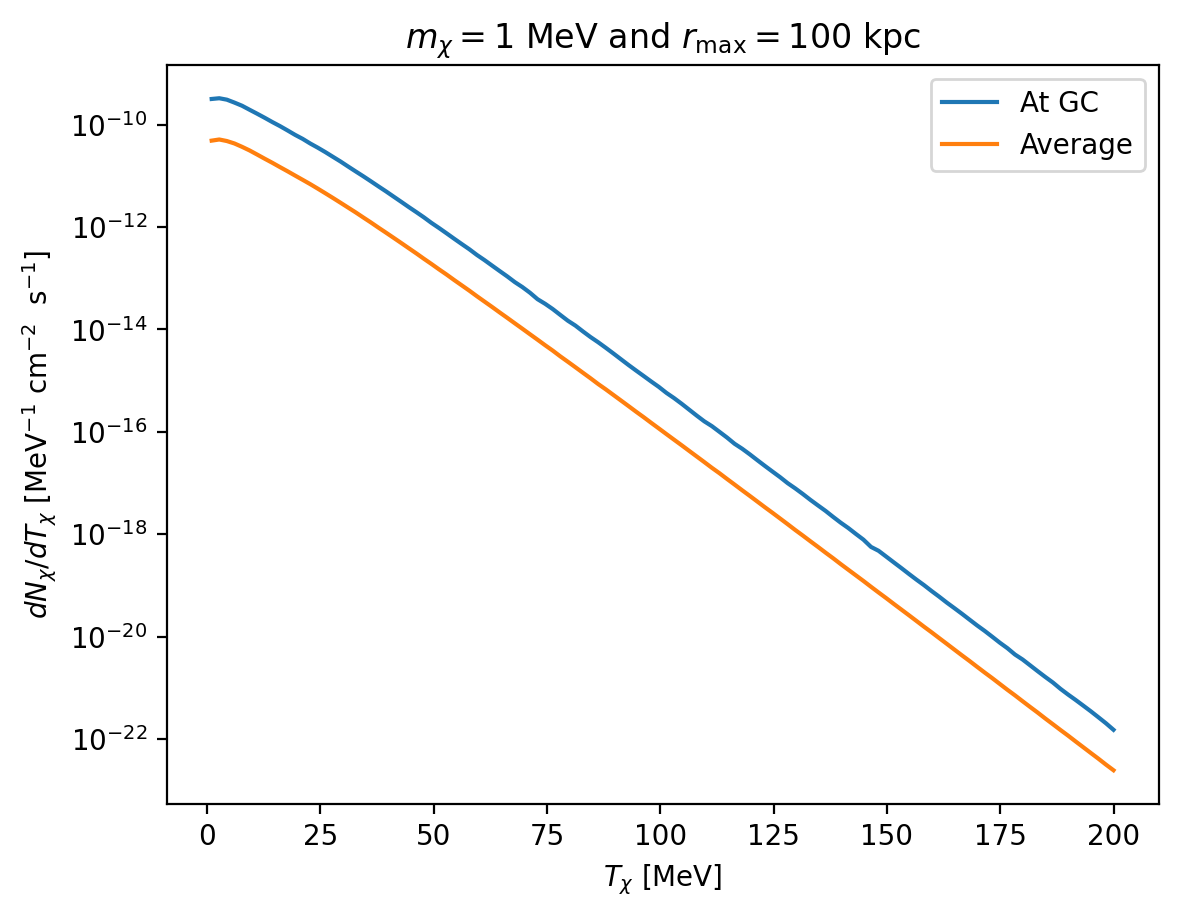

In [57]:
Nx = np.asarray(Nx)
Rccsn = 2.4607747599282348e-58
plt.plot(TxList,Nx.T[0]*Rccsn,label=r'At GC')
plt.plot(TxList,Nx.T[1]*Rccsn,label=r'Average')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$dN_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$  s$^{-1}$]')
plt.title(r'$m_\chi=1$ MeV and $r_{\rm max}=100$ kpc')
#plt.savefig('figures/DSNB_BDM.pdf',bbox_inches='tight')

Text(0.5, 1.0, '$m_\\chi=1$ MeV and $r_{\\rm max}=100$ kpc')

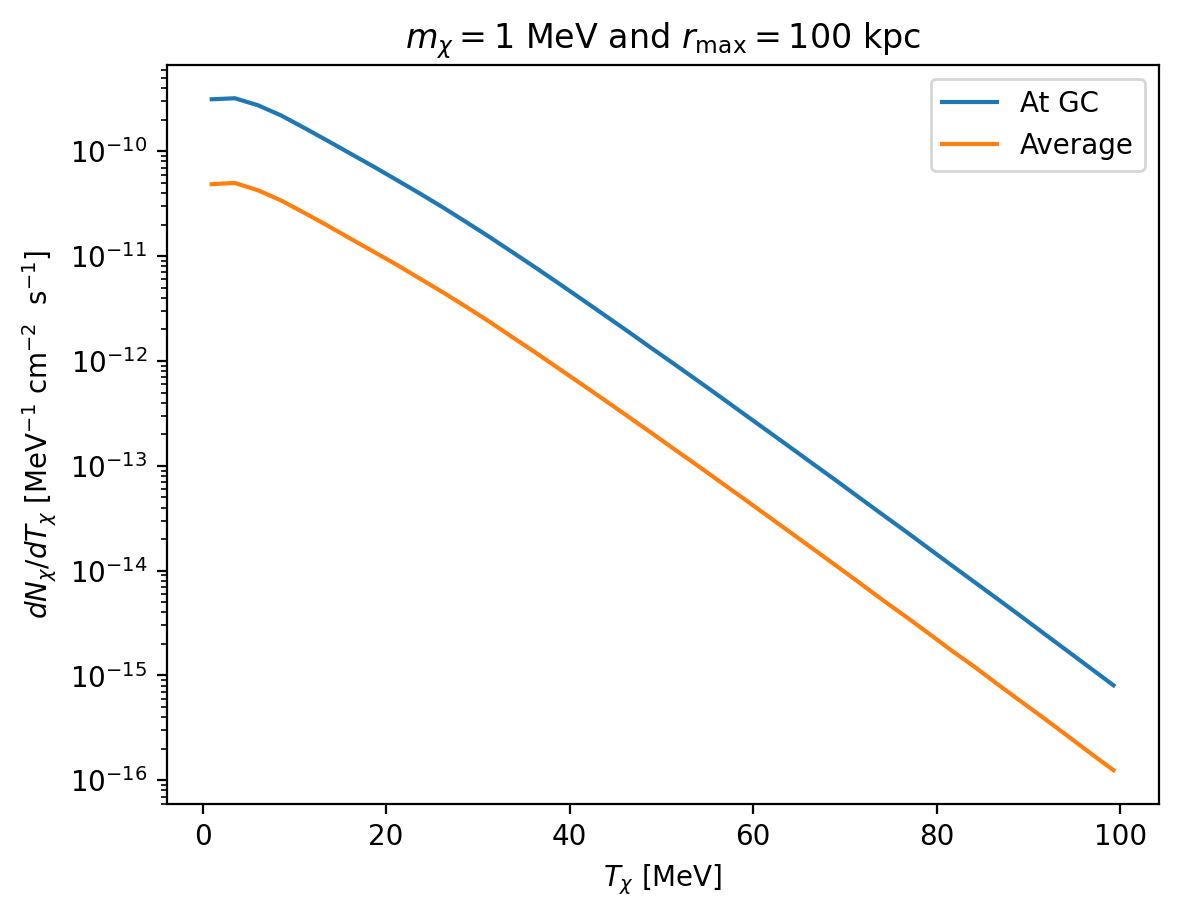

In [53]:
Nx = np.asarray(Nx)
Rccsn = 2.4607747599282348e-58
plt.plot(TxList[0:40],Nx.T[0,0:40]*Rccsn,label=r'At GC')
plt.plot(TxList[0:40],Nx.T[1,0:40]*Rccsn,label=r'Average')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$dN_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$  s$^{-1}$]')
plt.title(r'$m_\chi=1$ MeV and $r_{\rm max}=100$ kpc')

Text(0.5, 1.0, '$m_\\chi=1$ MeV and $r_{\\rm max}=100$ kpc')

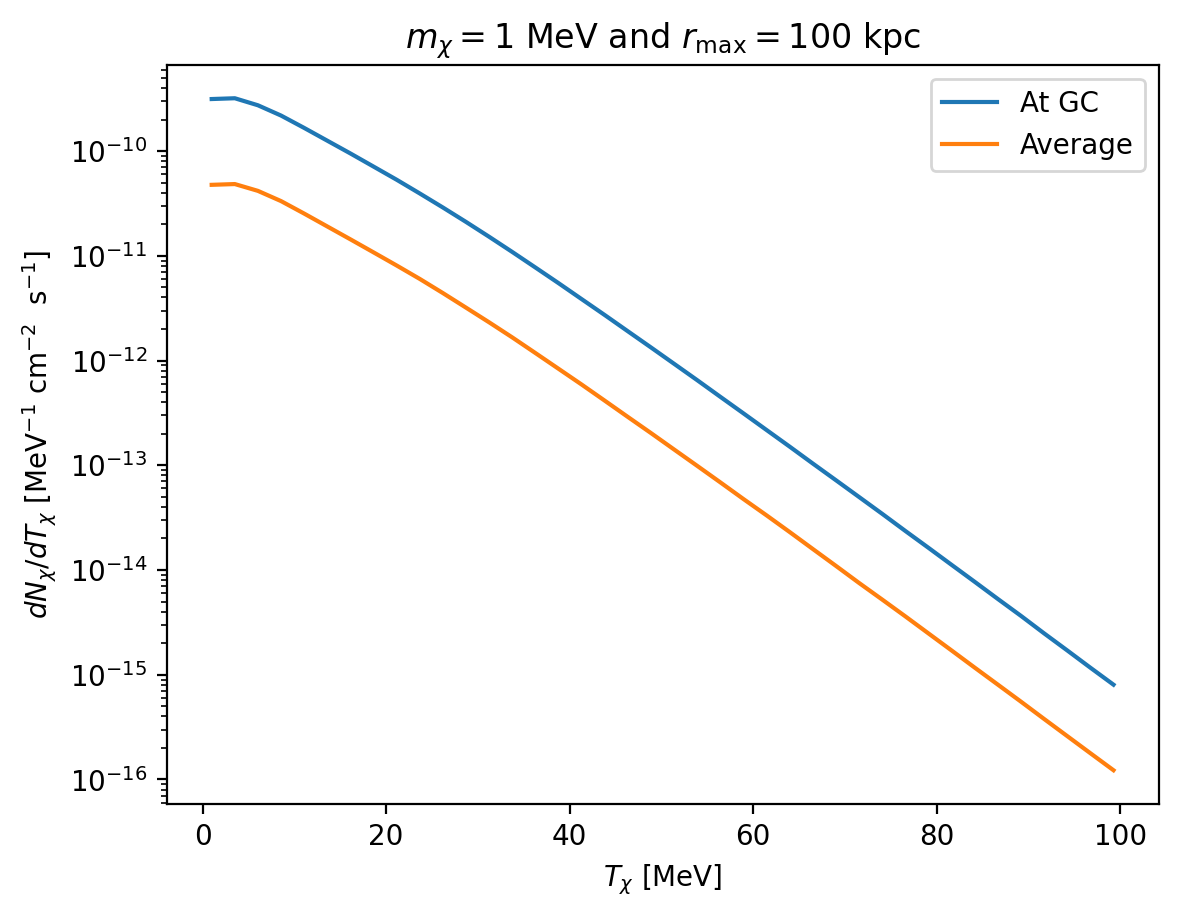

In [51]:
Nx = np.asarray(Nx)
Rccsn = 2.4607747599282348e-58
plt.plot(TxList[0:40],Nx.T[0,0:40]*Rccsn,label=r'At GC')
plt.plot(TxList[0:40],Nx.T[1,0:40]*Rccsn,label=r'Average')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$dN_\chi/dT_\chi$ [MeV$^{-1}$ cm$^{-2}$  s$^{-1}$]')
plt.title(r'$m_\chi=1$ MeV and $r_{\rm max}=100$ kpc')
#plt.savefig('figures/DSNB_BDM.pdf',bbox_inches='tight')

In [229]:
def dsnbSpectrum(Ev):
    Evtot = 3e58
    return 120*Evtot*Ev**2/7/np.pi**4/5**4/(np.exp(Ev/5)+1)

(1e-05, 10)

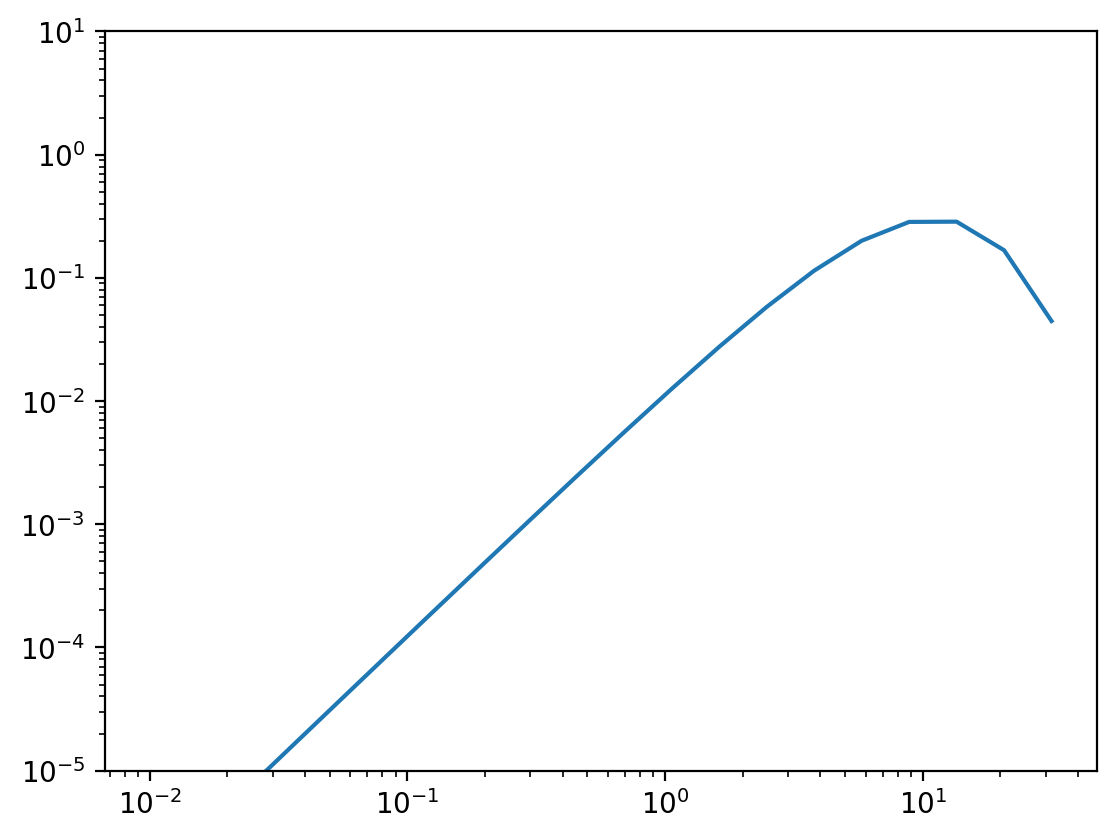

In [241]:
txList=np.logspace(-2,1.5,20)
plt.plot(txList,2*6*2.4607747599282348e-58*dsnbSpectrum(txList))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5,10)

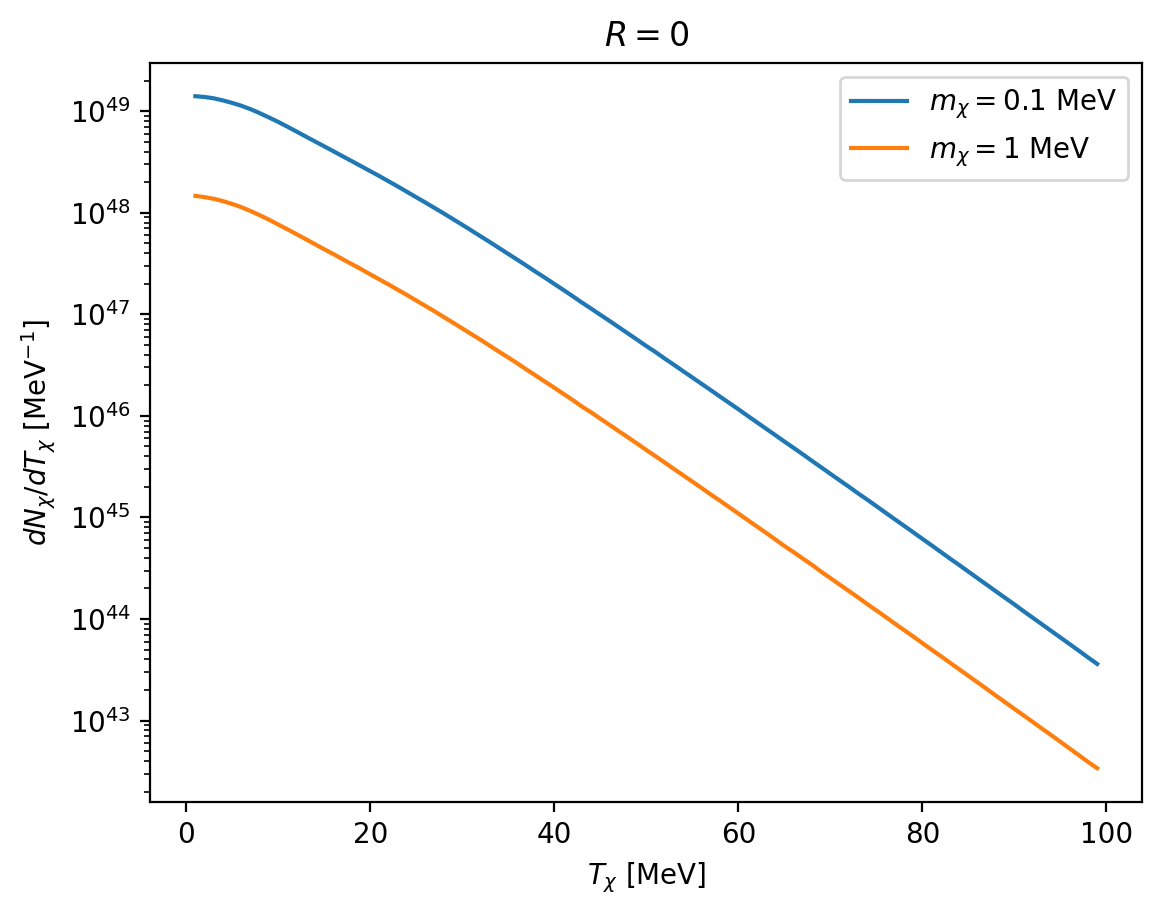

In [278]:
plt.plot(TxList,NvsT,label=r'$m_\chi=0.1$ MeV')
plt.plot(TxList,NvsT2,label=r'$m_\chi=1$ MeV')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$T_\chi$ [MeV]')
plt.ylabel(r'$dN_\chi/dT_\chi$ [MeV$^{-1}$]')
plt.title(r'$R=0$')
plt.savefig('figures/dNxdTx_at_GC.pdf',bbox_inches='tight')

In [304]:
dsnbBDM.totalSpectrumAverage(33,1,rbound=[1e-5,20],Rmax=50,tau=10,neval=15000)

6.229843316504471e+46

In [191]:
get_bdmSpectrum(10,0.1,5)

6.536617257845787e+26

In [134]:
get_bdmSpectrum(10,0.1,0,neval=15000)

1.4601933706025157e+49

In [111]:
get_bdmSpectrum(10,0.1,3,neval=3000)

1.7114766660529664e-13

In [115]:
get_bdmSpectrum(10,0.1,3,neval=3000)

5.254417606171903e-17

In [142]:
class dsnbBDM(constant):
    
    def __init__(self):
        pass
    
    # Fermi-Dirac distribution
    def __fv(Ev):
        pass
    
    @classmethod
    def nuSpectrum(cls,D,Ev):
        pass
    
    @classmethod
    def jx(cls,l,R,sigma,Ev):
        pass

375.63445041913343

In [190]:
sum([eval('7'+x) for x in ['5','7']])

152

In [188]:
sum([eval('5'),eval('7')])

12

In [93]:
list2 = []
for R in np.arange(-5,5,0.1):
    list2.append(zIntegrateDensity(R)[0])

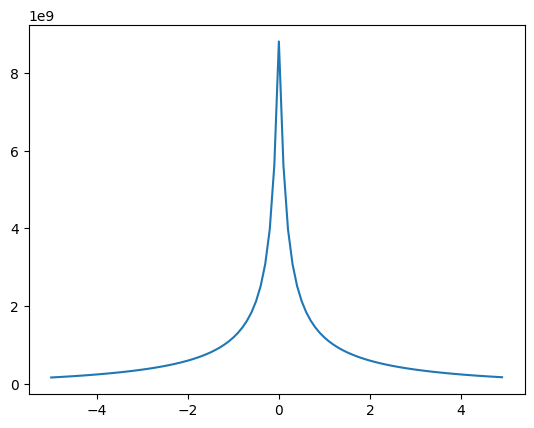

In [94]:
plt.plot(np.arange(-5,5,0.1),list2)
#plt.yscale('log')

In [206]:
fx = lambda z: sum( [z,z**2,z-4])

In [208]:
fx(5)

31

In [205]:
fx(5)

[5, 25, 1]

In [129]:
func = lambda x: eval('x+testR')

In [130]:
func(7)

12

In [8]:
def phi(M,Ms,phis,alpha):
    return phis*np.log(10)*(10**((M - Ms)*(1 + alpha)))*np.exp(-10**(M - Ms))

def phiz(M,z):
    if z <= 0.5:
        return phi(M,10**11.44,12.2e-4,-1.29)
    elif 0.5 < z <= 1:
        return phi(M,10**11.22,16.3e-4,-1.17)

In [9]:
phiz(1e8,0.5)

OverflowError: (34, 'Numerical result out of range')